This notebook combines audio clips into 5-second WAV files and then spectrograms of those WAV files.  These spectrograms are saved together as a numpy array in pickle format.

Also saves a pickle of labels for each spectrogram.

Can be used to generate training and validation data.  

Is currently set up to register 3 classes: 'enough', 'not_enough', 'empty'.

### starting point:

- Assume a folder `recorded_clips`, with subfolders of audio clips:
    - `empties` (`empties_da_train` and `empties_da_val`)
    - `enoughs` (`enoughs_da_train` and `enoughs_da_val`)
    - `notenoughs` (`notenoughs_da_train` and `notenoughs_da_val`)
    - `fullbackgrounds_trimmed_5sec` (etc)
    
- Can have any number of audio clips.  Only constraint is that the samples are all less than 5 seconds, and the background clips are all exactly 5 seconds.  (Can use `preprocess_audio` and `split_into_2_5sec_files` to turn 10+ second clips into 5 second clips, and `trim_to_5sec` to trim from 5+ seconds to exactly 5.)
- Probably want to augment data and split them into train and validation sets.  This is done with `data_augmentation` function below.
- Assume folders `XY_train` and `XY_val`, where the training and validation data will go after generated.

In [1]:
import numpy as np
from pydub import AudioSegment
import random
import sys
import io
import os
import glob
import IPython
from mb_utils import *
%matplotlib inline

import pickle

/anaconda/lib/python3.6/site-packages/pydub/utils.py:165: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)
Using TensorFlow backend.


In [2]:
from importlib import reload
import mb_utils

In [3]:
reload(mb_utils)
from mb_utils import *

In [4]:
Tx = 2754 #5511 # The number of time steps input to the model from the spectrogram
n_freq = 101 # Number of frequencies input to the model at each time step of the spectrogram
Ty = 1375 # The number of time steps in the output of our model

#### Files to work with (may not have all background versions):

In `recorded_clips` folder, have subfolders:

- `backgrounds`: 10 short (1-2 sec) WAV files of background noise
- `enoughs`: 10 WAV files of 'enough', each roughly 1 sec
- `notenoughs`: 10 WAV files of 'not enough', in the 1-3 sec range
- `fullbackgrounds_original`: 10 long (10+ sec) WAV files of background noise
- `fullbackgrounds_trimmed_10sec`: same as original, but trimmed to 10 seconds using `preprocess_audio`
- `fullbackgrounds_trimmed_5sec`: takes ten 10 sec clips and splits them into twenty 5 second clips.
- `literals`: 5 sec clips recorded without the background+clip process, for validation

### cutting and trimming clips (don't do unless necessary)

In [198]:
for i in range(10):
    #split_into_2_5sec_files('fullbackgrounds_trimmed_5sec', i)

recorded_clips/fullbackgrounds_trimmed_5sec/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec/09.wav


In [5]:
for i in range(56):
    #trim_to_5sec('fullbackgrounds_trimmed_5sec_collected', i)

recorded_clips/fullbackgrounds_trimmed_5sec_collected/00.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/01.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/02.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/03.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/04.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/05.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/06.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/07.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/08.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/09.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/10.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/11.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/12.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/13.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/14.wav
recorded_clips/fullbackgrounds_trimmed_5sec_collected/15.wav
recorded_clips/fullbackg

In [7]:
lit_counts = [20, 10, 10]
for i, folder in enumerate(['literal_empties', 'literal_enoughs', 'literal_notenoughs']):
    for i in range(lit_counts[i]):
        #trim_to_5sec(folder, i)

recorded_clips/literal_empties/00.wav
recorded_clips/literal_empties/01.wav
recorded_clips/literal_empties/02.wav
recorded_clips/literal_empties/03.wav
recorded_clips/literal_empties/04.wav
recorded_clips/literal_empties/05.wav
recorded_clips/literal_empties/06.wav
recorded_clips/literal_empties/07.wav
recorded_clips/literal_empties/08.wav
recorded_clips/literal_empties/09.wav
recorded_clips/literal_empties/10.wav
recorded_clips/literal_empties/11.wav
recorded_clips/literal_empties/12.wav
recorded_clips/literal_empties/13.wav
recorded_clips/literal_empties/14.wav
recorded_clips/literal_empties/15.wav
recorded_clips/literal_empties/16.wav
recorded_clips/literal_empties/17.wav
recorded_clips/literal_empties/18.wav
recorded_clips/literal_empties/19.wav
recorded_clips/literal_enoughs/00.wav
recorded_clips/literal_enoughs/01.wav
recorded_clips/literal_enoughs/02.wav
recorded_clips/literal_enoughs/03.wav
recorded_clips/literal_enoughs/04.wav
recorded_clips/literal_enoughs/05.wav
recorded_cli

### data augmentation (only if necessary)

For each file with filename length less than 8, multiplies it out into `n_pitch_shifts` x `n_time_stretches` copies, and adds suffixes to new clips.

In [5]:
# enoughs
data_augmentation('recorded_clips/enoughs_da_train/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)
data_augmentation('recorded_clips/enoughs_da_val/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)

00.wav
Pitch shifts (half steps):   [-1.76897852  0.032994    0.8996412  -0.72713485 -0.95017185]
Time stretches (multiplier): [1.06394128 1.02722182 1.08556844 0.99653322 1.06558525]
01.wav
Pitch shifts (half steps):   [-0.71408442 -0.56108405 -0.08938008  0.86958928  0.67964865]
Time stretches (multiplier): [0.88456453 1.06142358 1.01094138 1.0181243  1.05108263]
02.wav
Pitch shifts (half steps):   [-1.18516305  0.4333326  -0.27703503 -0.40490943  0.00236691]
Time stretches (multiplier): [1.03121183 0.95712948 1.15990587 0.82703828 0.91047872]
03.wav
Pitch shifts (half steps):   [ 0.22642807  0.40937898 -1.63108404  0.2816933  -0.1747362 ]
Time stretches (multiplier): [0.94673224 1.17014522 1.01737507 1.16605146 0.92600662]
04.wav
Pitch shifts (half steps):   [-0.49334469 -0.53452658  0.21125161 -1.1167618  -0.89020224]
Time stretches (multiplier): [0.91455355 1.14169981 1.09035879 0.8085518  0.91410321]
05.wav
Pitch shifts (half steps):   [ 1.16919619  0.89452245  0.72205445  0.3540

In [6]:
# not enoughs
data_augmentation('recorded_clips/notenoughs_da_train/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)
data_augmentation('recorded_clips/notenoughs_da_val/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)

00.wav
Pitch shifts (half steps):   [ 0.80467504 -0.70651181  0.50403287  0.90619419 -0.05793764]
Time stretches (multiplier): [1.04953514 0.98107372 0.97248841 1.08217756 1.06109861]
01.wav
Pitch shifts (half steps):   [ 0.47967635 -0.5865997  -1.55441447  1.03574451  1.24157365]
Time stretches (multiplier): [0.96583952 1.05170447 0.99238287 0.86453589 1.03185443]
02.wav
Pitch shifts (half steps):   [-0.33197163  0.56441123  0.56763003  1.53058051 -0.55288814]
Time stretches (multiplier): [0.961212   1.00039485 1.10413021 0.97951759 0.74557722]
03.wav
Pitch shifts (half steps):   [-1.31170795 -0.37589609 -0.13580849  0.54779245  0.8553179 ]
Time stretches (multiplier): [1.22325578 1.21101972 0.92184692 1.14531914 1.15603869]
04.wav
Pitch shifts (half steps):   [-0.09819419  0.31101522  1.00448431 -0.52447532 -0.71498585]
Time stretches (multiplier): [1.05807751 0.97047582 0.87677134 0.96625814 0.83948691]
05.wav
Pitch shifts (half steps):   [ 0.54637446  0.75239968  0.31898806  0.5306

In [7]:
# empties
data_augmentation('recorded_clips/empties_da_train/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)
data_augmentation('recorded_clips/empties_da_val/', n_pitch_shifts=5, n_time_stretches=5, ps_sigma=1.5, ts_sigma=0.2)

00.wav
Pitch shifts (half steps):   [-1.18316429  2.04933859  0.47881349  0.81600376  0.59125242]
Time stretches (multiplier): [0.89325033 0.8889779  1.0172474  1.00845371 0.88890216]
01.wav
Pitch shifts (half steps):   [-0.51232557 -0.9578144  -0.58126588  0.66572872 -0.28866855]
Time stretches (multiplier): [1.11187609 1.15343407 1.11875067 1.07367476 0.88507175]
02.wav
Pitch shifts (half steps):   [-1.40061346  0.04636889 -0.80034278 -0.1474268   0.72729373]
Time stretches (multiplier): [0.96872995 0.98704542 0.86603973 1.08166534 0.90707502]
03.wav
Pitch shifts (half steps):   [ 0.77180471  1.63086257  0.30242568 -0.95550246 -0.4195652 ]
Time stretches (multiplier): [0.96110481 0.92841564 0.93239259 0.9816912  0.92555879]
04.wav
Pitch shifts (half steps):   [ 1.13571156  0.21656462 -1.27518087  0.76708955 -0.61417415]
Time stretches (multiplier): [1.1632008  0.94577726 1.04309612 0.90517126 1.00696768]
05.wav
Pitch shifts (half steps):   [ 0.62931032  0.0865326   0.14051394 -0.5782

#### for backgrounds

In [22]:
# randomly put 80% of original background clips into train, and 20% into val
split_into_train_test('recorded_clips/backgrounds5sec', 0.8, seed=134)

In [24]:
# augment original clips.  NOTE: no time shift, so they stay at 5 secs.
data_augmentation('recorded_clips/backgrounds5sec_da_train/', n_pitch_shifts=2, 
                  n_time_stretches=0, ps_sigma=4.0)
data_augmentation('recorded_clips/backgrounds5sec_da_val/', n_pitch_shifts=2, 
                  n_time_stretches=0, ps_sigma=4.0)

01.wav
Pitch shifts (half steps):   [-2.480958   -0.07727226]
Time stretches (multiplier): [1]
02.wav
Pitch shifts (half steps):   [4.37400039 3.15698804]
Time stretches (multiplier): [1]
04.wav
Pitch shifts (half steps):   [-0.24663359  1.3163557 ]
Time stretches (multiplier): [1]
06.wav
Pitch shifts (half steps):   [-1.01574552  3.71622312]
Time stretches (multiplier): [1]
07.wav
Pitch shifts (half steps):   [1.86449016 0.93911908]
Time stretches (multiplier): [1]
08.wav
Pitch shifts (half steps):   [-1.32233313 -0.31528574]
Time stretches (multiplier): [1]
09.wav
Pitch shifts (half steps):   [-2.72795936 -0.9642862 ]
Time stretches (multiplier): [1]
10.wav
Pitch shifts (half steps):   [2.02150115 0.38031476]
Time stretches (multiplier): [1]
11.wav
Pitch shifts (half steps):   [1.69845323 1.56674034]
Time stretches (multiplier): [1]
12.wav
Pitch shifts (half steps):   [-0.3278478  -0.84683742]
Time stretches (multiplier): [1]
14.wav
Pitch shifts (half steps):   [-1.43641315 -4.767450

a0056.wav
Pitch shifts (half steps):   [-0.9094771  -0.21596317]
Time stretches (multiplier): [1]
a0057.wav
Pitch shifts (half steps):   [ 2.21407397 -1.09771795]
Time stretches (multiplier): [1]
a0058.wav
Pitch shifts (half steps):   [ 1.93284961 -0.11651699]
Time stretches (multiplier): [1]
a0059.wav
Pitch shifts (half steps):   [-0.06172091 -1.79502653]
Time stretches (multiplier): [1]
a0061.wav
Pitch shifts (half steps):   [ 0.98272561 -1.08361257]
Time stretches (multiplier): [1]
a0062.wav
Pitch shifts (half steps):   [0.7826645  1.29462916]
Time stretches (multiplier): [1]
a0063.wav
Pitch shifts (half steps):   [ 2.4223706  -0.08364319]
Time stretches (multiplier): [1]
a0064.wav
Pitch shifts (half steps):   [1.76280499 1.22892905]
Time stretches (multiplier): [1]
a0066.wav
Pitch shifts (half steps):   [-0.55658874 -1.79336787]
Time stretches (multiplier): [1]
a0067.wav
Pitch shifts (half steps):   [-1.79204286 -0.0926347 ]
Time stretches (multiplier): [1]
a0068.wav
Pitch shifts (

a0166.wav
Pitch shifts (half steps):   [0.23453925 1.73255026]
Time stretches (multiplier): [1]
a0167.wav
Pitch shifts (half steps):   [ 0.87306687 -1.26897496]
Time stretches (multiplier): [1]
a0168.wav
Pitch shifts (half steps):   [-2.15329537 -1.04557888]
Time stretches (multiplier): [1]
a0171.wav
Pitch shifts (half steps):   [-0.78536285 -0.72717203]
Time stretches (multiplier): [1]
a0172.wav
Pitch shifts (half steps):   [ 0.43607202 -0.20398241]
Time stretches (multiplier): [1]
a0173.wav
Pitch shifts (half steps):   [-1.59853151 -1.13211101]
Time stretches (multiplier): [1]
a0175.wav
Pitch shifts (half steps):   [-0.97072682  1.8970258 ]
Time stretches (multiplier): [1]
a0176.wav
Pitch shifts (half steps):   [-0.80665552  2.19684356]
Time stretches (multiplier): [1]
a0177.wav
Pitch shifts (half steps):   [-0.85627669  0.76900157]
Time stretches (multiplier): [1]
a0178.wav
Pitch shifts (half steps):   [ 1.56303616 -2.36521304]
Time stretches (multiplier): [1]
a0179.wav
Pitch shifts

a0267.wav
Pitch shifts (half steps):   [ 1.15570524 -1.59108476]
Time stretches (multiplier): [1]
a0268.wav
Pitch shifts (half steps):   [5.37511409 3.42296406]
Time stretches (multiplier): [1]
a0269.wav
Pitch shifts (half steps):   [ 1.14075364 -1.59263582]
Time stretches (multiplier): [1]
a0271.wav
Pitch shifts (half steps):   [-0.24288882  3.48616581]
Time stretches (multiplier): [1]
a0272.wav
Pitch shifts (half steps):   [-0.88947245  2.82356566]
Time stretches (multiplier): [1]
a0273.wav
Pitch shifts (half steps):   [2.70749703 3.21700231]
Time stretches (multiplier): [1]
a0274.wav
Pitch shifts (half steps):   [ 1.74405365 -0.23374089]
Time stretches (multiplier): [1]
a0275.wav
Pitch shifts (half steps):   [-3.59282622 -0.87619506]
Time stretches (multiplier): [1]
a0276.wav
Pitch shifts (half steps):   [-0.22237785  1.17938279]
Time stretches (multiplier): [1]
a0277.wav
Pitch shifts (half steps):   [1.99858092 3.74006654]
Time stretches (multiplier): [1]
a0283.wav
Pitch shifts (ha

b0021.wav
Pitch shifts (half steps):   [-0.29748028 -1.8447425 ]
Time stretches (multiplier): [1]
b0022.wav
Pitch shifts (half steps):   [-1.20330989  2.88662991]
Time stretches (multiplier): [1]
b0023.wav
Pitch shifts (half steps):   [0.32071915 1.90574115]
Time stretches (multiplier): [1]
b0024.wav
Pitch shifts (half steps):   [-3.24043408 -1.22513304]
Time stretches (multiplier): [1]
b0025.wav
Pitch shifts (half steps):   [-1.84155781  1.8748021 ]
Time stretches (multiplier): [1]
b0026.wav
Pitch shifts (half steps):   [-2.6877351   6.07792883]
Time stretches (multiplier): [1]
b0027.wav
Pitch shifts (half steps):   [-4.29460021  1.50203908]
Time stretches (multiplier): [1]
b0029.wav
Pitch shifts (half steps):   [-2.43936563 -2.70819613]
Time stretches (multiplier): [1]
b0030.wav
Pitch shifts (half steps):   [-1.32729385  3.29354721]
Time stretches (multiplier): [1]
b0031.wav
Pitch shifts (half steps):   [0.02748409 2.87039379]
Time stretches (multiplier): [1]
b0033.wav
Pitch shifts (

b0125.wav
Pitch shifts (half steps):   [-1.75811653  1.409366  ]
Time stretches (multiplier): [1]
b0126.wav
Pitch shifts (half steps):   [ 4.27388734 -3.35690216]
Time stretches (multiplier): [1]
b0127.wav
Pitch shifts (half steps):   [1.48340533 2.4355513 ]
Time stretches (multiplier): [1]
b0128.wav
Pitch shifts (half steps):   [-2.53752558 -1.6368415 ]
Time stretches (multiplier): [1]
b0129.wav
Pitch shifts (half steps):   [ 2.66084428 -0.25807492]
Time stretches (multiplier): [1]
b0130.wav
Pitch shifts (half steps):   [ 3.12657071 -0.93796836]
Time stretches (multiplier): [1]
b0131.wav
Pitch shifts (half steps):   [ 0.56339654 -3.51361974]
Time stretches (multiplier): [1]
b0132.wav
Pitch shifts (half steps):   [ 0.84212155 -0.04249416]
Time stretches (multiplier): [1]
b0134.wav
Pitch shifts (half steps):   [ 3.16721475 -0.87802788]
Time stretches (multiplier): [1]
b0135.wav
Pitch shifts (half steps):   [-0.78616321  1.09483131]
Time stretches (multiplier): [1]
b0137.wav
Pitch shifts

b0235.wav
Pitch shifts (half steps):   [-1.99623958  0.67824429]
Time stretches (multiplier): [1]
b0236.wav
Pitch shifts (half steps):   [-2.36854849 -0.40758869]
Time stretches (multiplier): [1]
b0237.wav
Pitch shifts (half steps):   [-2.48152634  1.15847414]
Time stretches (multiplier): [1]
b0240.wav
Pitch shifts (half steps):   [3.23577018 4.78669654]
Time stretches (multiplier): [1]
b0241.wav
Pitch shifts (half steps):   [3.22041857 1.38466086]
Time stretches (multiplier): [1]
b0242.wav
Pitch shifts (half steps):   [-0.43571568 -2.16895381]
Time stretches (multiplier): [1]
b0243.wav
Pitch shifts (half steps):   [0.08824213 1.86565487]
Time stretches (multiplier): [1]
b0245.wav
Pitch shifts (half steps):   [-1.13160134  0.60833346]
Time stretches (multiplier): [1]
b0247.wav
Pitch shifts (half steps):   [-3.95984146 -0.01872962]
Time stretches (multiplier): [1]
b0248.wav
Pitch shifts (half steps):   [1.58464599 0.06123661]
Time stretches (multiplier): [1]
b0249.wav
Pitch shifts (half

b0340.wav
Pitch shifts (half steps):   [0.71924836 3.48912372]
Time stretches (multiplier): [1]
b0341.wav
Pitch shifts (half steps):   [ 2.33708053 -1.84116527]
Time stretches (multiplier): [1]
b0342.wav
Pitch shifts (half steps):   [3.62967136 0.28597835]
Time stretches (multiplier): [1]
b0343.wav
Pitch shifts (half steps):   [0.50187324 0.05169517]
Time stretches (multiplier): [1]
b0344.wav
Pitch shifts (half steps):   [-1.52943089  1.21061423]
Time stretches (multiplier): [1]
b0347.wav
Pitch shifts (half steps):   [-0.56211235 -1.77395845]
Time stretches (multiplier): [1]
b0348.wav
Pitch shifts (half steps):   [ 0.56391483 -1.72623054]
Time stretches (multiplier): [1]
b0349.wav
Pitch shifts (half steps):   [ 1.76887275 -0.93822036]
Time stretches (multiplier): [1]
b0350.wav
Pitch shifts (half steps):   [ 2.09795408 -0.17991121]
Time stretches (multiplier): [1]
b0351.wav
Pitch shifts (half steps):   [-0.31104546  5.35577558]
Time stretches (multiplier): [1]
b0354.wav
Pitch shifts (ha

a0280.wav
Pitch shifts (half steps):   [-1.1704823  -0.54001329]
Time stretches (multiplier): [1]
a0281.wav
Pitch shifts (half steps):   [-3.09261782 -1.91570326]
Time stretches (multiplier): [1]
a0282.wav
Pitch shifts (half steps):   [0.23200762 1.07406616]
Time stretches (multiplier): [1]
a0285.wav
Pitch shifts (half steps):   [1.55450247 0.08567574]
Time stretches (multiplier): [1]
a0287.wav
Pitch shifts (half steps):   [1.37160943 1.10802212]
Time stretches (multiplier): [1]
a0291.wav
Pitch shifts (half steps):   [-2.14387253  0.0739886 ]
Time stretches (multiplier): [1]
a0293.wav
Pitch shifts (half steps):   [ 4.49748156 -1.24971323]
Time stretches (multiplier): [1]
a0301.wav
Pitch shifts (half steps):   [0.565053   1.00052669]
Time stretches (multiplier): [1]
a0306.wav
Pitch shifts (half steps):   [-5.00759537  2.3240055 ]
Time stretches (multiplier): [1]
a0307.wav
Pitch shifts (half steps):   [-0.0872912   1.64723614]
Time stretches (multiplier): [1]
a0308.wav
Pitch shifts (half

b0317.wav
Pitch shifts (half steps):   [ 0.22832908 -2.63440923]
Time stretches (multiplier): [1]
b0321.wav
Pitch shifts (half steps):   [0.2138253  4.22056997]
Time stretches (multiplier): [1]
b0322.wav
Pitch shifts (half steps):   [-0.8809053  -1.57647923]
Time stretches (multiplier): [1]
b0334.wav
Pitch shifts (half steps):   [0.43277525 0.52841705]
Time stretches (multiplier): [1]
b0339.wav
Pitch shifts (half steps):   [ 0.60635089 -3.59428114]
Time stretches (multiplier): [1]
b0345.wav
Pitch shifts (half steps):   [2.57291016 0.38306006]
Time stretches (multiplier): [1]
b0346.wav
Pitch shifts (half steps):   [-4.48582818  4.45346072]
Time stretches (multiplier): [1]
b0352.wav
Pitch shifts (half steps):   [3.87221724 4.23103062]
Time stretches (multiplier): [1]
b0353.wav
Pitch shifts (half steps):   [ 5.86101354 -4.19043346]
Time stretches (multiplier): [1]
b0357.wav
Pitch shifts (half steps):   [2.33643188 1.46296737]
Time stretches (multiplier): [1]
b0359.wav
Pitch shifts (half s

### make training dataset and save to disk

In [37]:
# choose with clip folders to use, to use data augmentation or not
clips_location_dict_train = {'enough': 'recorded_clips/enoughs_da_train',
                      'not_enough':  'recorded_clips/notenoughs_da_train',
                      'empty': 'recorded_clips/empties_da_train',
                      'backgrounds': 'recorded_clips/backgrounds5sec_da_train/'}

# load audio samples from disk
clips_dict = load_raw_audio(clips_location_dict_train)

enoughs = clips_dict['enough']
notenoughs = clips_dict['not_enough']
backgrounds = clips_dict['backgrounds']
empties = clips_dict['empty']

enough............468 clips.
not_enough........390 clips.
empty.............260 clips.
backgrounds.......1827 clips.


sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199

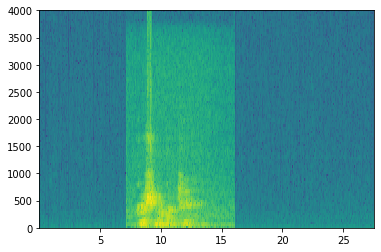

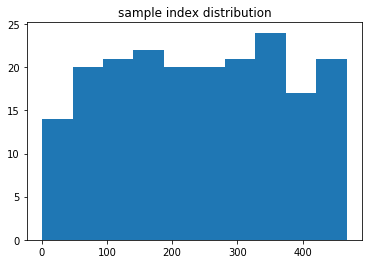

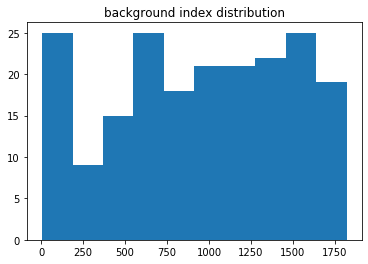

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199

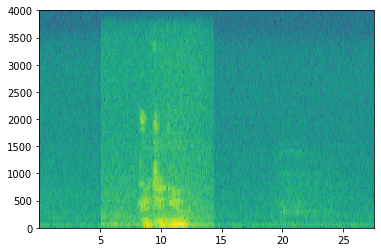

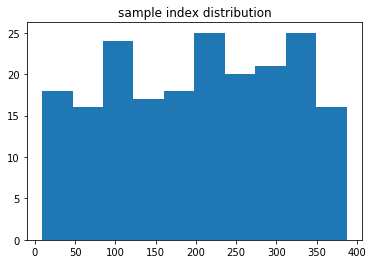

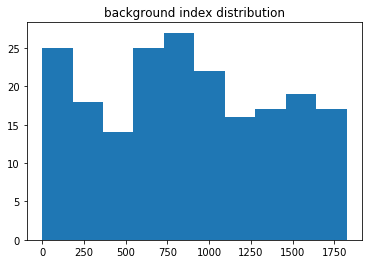

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 2

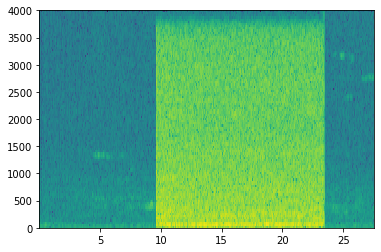

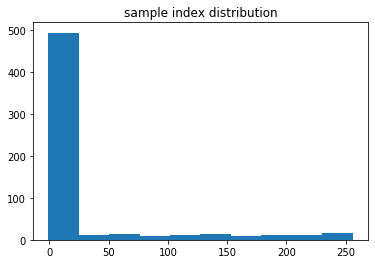

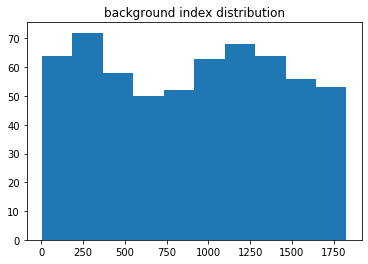

size of X:  (1000, 2754, 101)
length of y: 1000
Features saved to: XY_train/X_1000_5sec_v7.pkl
Labels saved to: XY_train/y_1000_5sec_v7.pkl


In [45]:
# do this repeatedly and change the file_comment, to make multiple datasets
n_enoughs = 200
n_notenoughs = 200
n_empties = 600
file_folder='XY_train'
file_comment='1000_5sec_v7'

X_training, y_training = make_features_and_labels(n_enoughs, n_notenoughs, n_empties, 
                                                  enoughs, notenoughs, empties, backgrounds, Tx, n_freq, Ty)

save_datasets_to_disk(X_training, y_training, file_folder, file_comment)

#### make smaller validation set

In [35]:
# choose with clip folders to use, to use data augmentation or not
clips_location_dict_val = {'enough': 'recorded_clips/enoughs_da_val',
                      'not_enough':  'recorded_clips/notenoughs_da_val',
                      'empty': 'recorded_clips/empties_da_val',
                      'backgrounds': 'recorded_clips/backgrounds5sec_da_val/'}

# load audio samples from disk
clips_dict = load_raw_audio(clips_location_dict_val)

enoughs = clips_dict['enough']
notenoughs = clips_dict['not_enough']
backgrounds = clips_dict['backgrounds']
empties = clips_dict['empty']

enough............130 clips.
not_enough........104 clips.
empty.............52 clips.
backgrounds.......501 clips.


sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

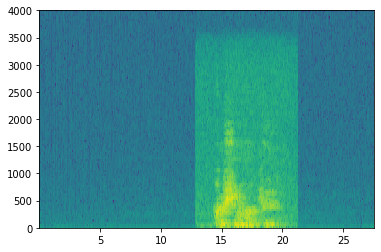

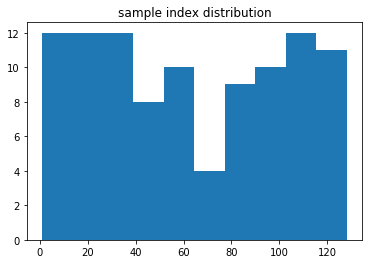

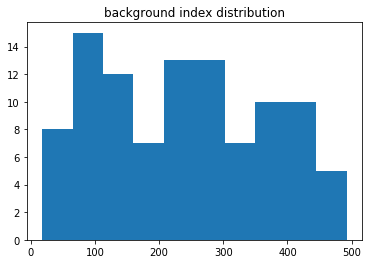

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99

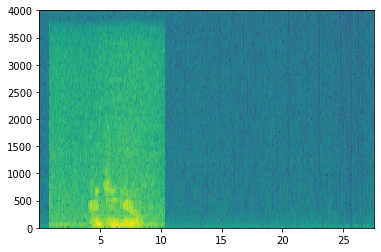

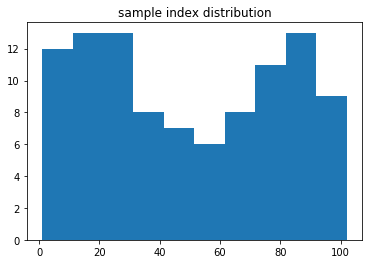

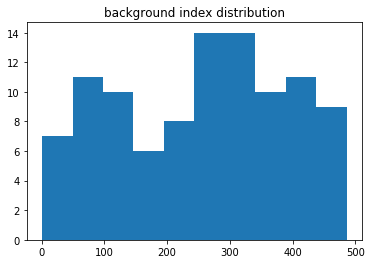

sample:  0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199

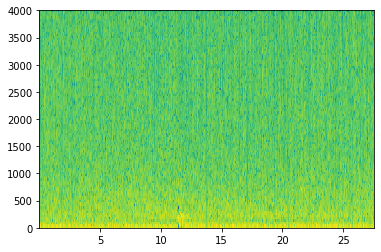

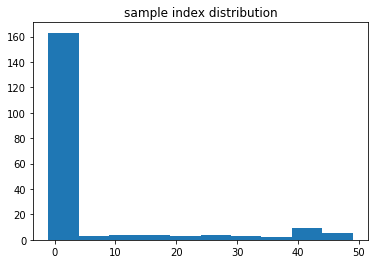

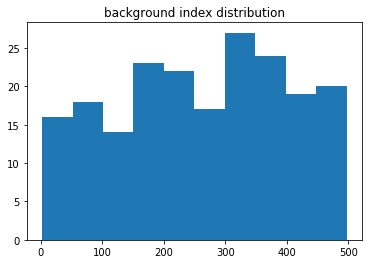

size of X:  (400, 2754, 101)
length of y: 400
Features saved to: XY_val/X_400_5sec_100_100_200.pkl
Labels saved to: XY_val/y_400_5sec_100_100_200.pkl


In [36]:
n_enoughs = 100
n_notenoughs = 100
n_empties = 200
file_folder='XY_val'
file_comment='400_5sec_100_100_200'

X_val, y_val = make_features_and_labels(n_enoughs, n_notenoughs, n_empties, 
                                                  enoughs, notenoughs, empties, backgrounds, Tx, n_freq, Ty)

save_datasets_to_disk(X_val, y_val, file_folder, file_comment)

#### make literal validation set -- doesn't seem necessary actually

In [24]:
reload(mb_utils)
from mb_utils import *

In [15]:
# choose with clip folders to use, to use data augmentation or not
clips_location_dict_val = {'enough': 'recorded_clips/literal_enoughs',
                          'not_enough': 'recorded_clips/literal_notenoughs',
                          'empty': 'recorded_clips/literal_empties',
                          'backgrounds': 'recorded_clips/literal_empties'}  # backgrounds is a placeholder, not used

# load audio samples from disk
clips_dict = load_raw_audio(clips_location_dict_val)

enoughs = clips_dict['enough']
notenoughs = clips_dict['not_enough']
backgrounds = clips_dict['backgrounds']
empties = clips_dict['empty']

enough............1 clips.
not_enough........1 clips.
empty.............1 clips.
backgrounds.......1 clips.


sample:  0literal


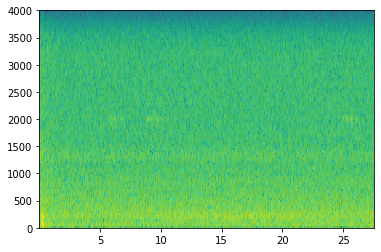

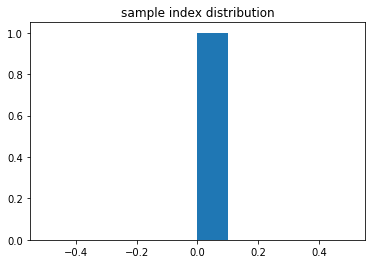

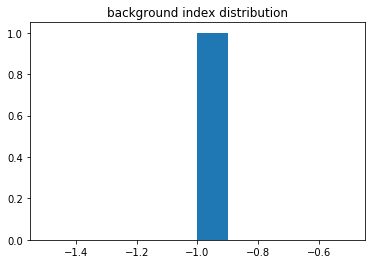

sample:  0literal


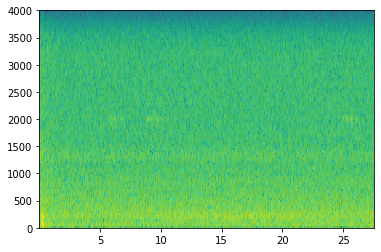

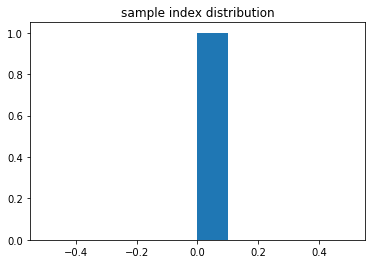

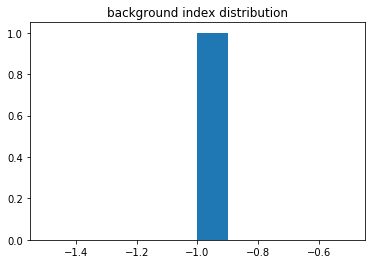

sample:  0literal


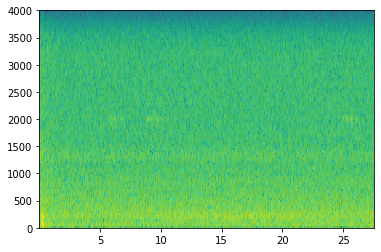

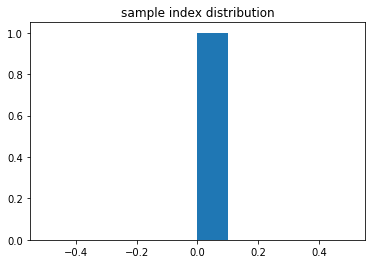

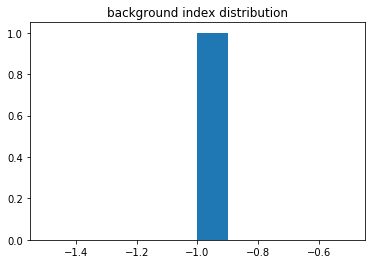

size of X:  (3, 2754, 101)
length of y: 3
Features saved to: XY_literal_val/X_1_1_1.pkl
Labels saved to: XY_literal_val/y_1_1_1.pkl


In [26]:
n_enoughs = len(enoughs)
n_notenoughs = len(notenoughs)
n_empties = len(empties)
file_folder='XY_literal_val'
file_comment='{}_{}_{}'.format(n_enoughs, n_notenoughs, n_empties)

X_val, y_val = make_features_and_labels(n_enoughs, n_notenoughs, n_empties, 
                                       enoughs, notenoughs, empties, backgrounds, Tx, n_freq, Ty,
                                       literal=True)

save_datasets_to_disk(X_val, y_val, file_folder, file_comment)